__File: toy_potential_phase_shifts.ipynb__

__Author:   A. J. Tropiano (tropiano.4@osu.edu)__<br/>
__Date:     Jun 17, 2020__

This notebook tests Gauss-Legendre quadrature momentum mesh dependence by evaluating a toy potential's phase shifts at its eigenenergies.

In [1]:
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import numpy.linalg as la
from numpy.polynomial.legendre import leggauss
# Scripts made by A.T.
from observables import phase_shifts

In [2]:
# Construct Gauss-Legendre quadrature momentum mesh (units are fm^-1)

# Minimum momentum value
k_min = 0.0
# Maximum momentum value
k_max = 30.0
# Number of nodes
ntot = 20
x_array, k_weights = leggauss(ntot)
# Convert from interval [-1, 1] to [k_min, k_max] (meaning x_array -> k_array)
k_array = 0.5 * (x_array + 1) * (k_max - k_min) + k_min

In [3]:
# Calculate relative kinetic energy

# h-bar^2 / M [MeV fm^2]
hbar_sq_over_M = 41.47
# Relative kinetic energy in units MeV
T_matrix = hbar_sq_over_M * np.diag( k_array**2 )

__Details of toy NN potential__:

Toy potential for proton-neutron scattering for the $^1$S$_0$ partial wave. Fit to experimental phase shifts and is given in coordinate space by $V(r)=V_a e^{-a x} / x + V_b e^{-b x} / x + V_c e^{-c x} / x$, where $x = \mu r$, $\mu = 0.7$ fm$^{−1}$ (the inverse of the pion mass), $V_a = −10.463$ MeV and $a=1$, $V_b =−1650.6$ MeV and $b=4$ and $V_c = 6484.3$ MeV and $c=7$. In momentum space, $V_{\eta} e^{-\eta x} / x \rightarrow V_{\eta} / (4 \mu k k') log[( (\mu \eta)^2 + (k+k')^2 ) / ( (\mu \eta)^2 + (k-k')^2 ) ]$. We skip to this step in what follows.

In [4]:
# Set up potential from PHY 989 project: 1S0 parameterization for NN scattering

# Parameters
mu = 0.7 # fm^-1
V_a = -10.463 # MeV
a = 1
V_b = -1650.6 # MeV
b = 4
V_c = 6484.3 # MeV
c = 7

# Get rows and columns of momentum values
row, col = np.meshgrid(k_array, k_array)

# Construct momentum-space potential in units MeV fm^3
V_matrix = V_a / (4 * mu * row * col) * np.log( ( (mu*a)**2 + (row+col)**2 ) / ( (mu*a)**2 + (row-col)**2 ) ) + \
           V_b / (4 * mu * row * col) * np.log( ( (mu*b)**2 + (row+col)**2 ) / ( (mu*b)**2 + (row-col)**2 ) ) + \
           V_c / (4 * mu * row * col) * np.log( ( (mu*c)**2 + (row+col)**2 ) / ( (mu*c)**2 + (row-col)**2 ) )

In [5]:
# Obtain Hamiltonian in units MeV and calculate eigenenergies

# Convert potential to units MeV
factor_array = np.sqrt( (2*k_weights) / np.pi ) * k_array # fm^-3/2
factor_row, factor_col = np.meshgrid(factor_array, factor_array)

# Add to T_rel to get Hamiltonian in units MeV
H_matrix = T_matrix + factor_row * factor_col * V_matrix

# Get eigenvalues
eigenvalues, eigenvectors = la.eigh(H_matrix)
print('--- Eigenenergies [MeV] ---')
for eig in eigenvalues:
    print('%.3f' % eig)

--- Eigenenergies [MeV] ---
0.440
12.259
75.799
265.125
669.610
1374.984
2456.876
3974.915
5965.331
8433.537
11348.500
14640.240
18201.073
21890.606
25544.026
28982.858
32027.218
34508.834
36283.810
37245.854


In [6]:
# Calculate phase shifts of V(k,k') at eigenenergies
# Function takes E_lab as argument -> multiply eigenenergies by 2 (then it will evaluate at E_lab = 2*E_i which
# gives E_CoM = E_i)

delta_array = phase_shifts(2*eigenvalues, V_matrix, k_array, k_weights)

# # Manually correct shifts in \pi
# for i, delta in enumerate(delta_array):
#     if e_array[i] < 50.0 and delta < 0.0:
#         delta_array[i] = delta + 180.0

# You will run into a problem where k0 = np.sqrt( E / hbar_sq_over_M ) > k_max of mesh
# This gives a RuntimeWarning because the log function has a negative value - get rid of the NaN

e_array = np.zeros(ntot)
for i in range(ntot):
    if np.isnan(delta_array[i]):
        e_array = np.delete(eigenvalues, i)
        delta_array = np.delete(delta_array, i)
    else:
        e_array = eigenvalues[i]

/Users/anthonytropiano/Documents/GitHub/LENT/observables.py:217: RuntimeWarning: invalid value encountered in log
  ( k_max - k0 ) ) / ( 2.0*k0 ) )


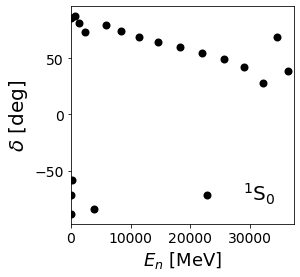

In [7]:
# Plot phase shifts

# Figure size
width = 4
height = 4
figure_size = (width, height)
    
# x-axis limit
xlim = [0.0, max(eigenvalues)]
        
# Axes labels and fontsize
x_label = r'$E_n$' + ' [MeV]'
x_label_size = 18
y_label = r'$\delta$' + ' [deg]'
y_label_size = 20
axes_tick_size = 14
    
# Curve width
curve_width = 2.0

# Curve color, styles, and labels
curve_color = 'xkcd:black'
curve_label = r'$^1$' + 'S' + r'$_0$'

# Initialize figure
plt.close('all')
f, ax = plt.subplots(figsize=figure_size) 
        
# Add curve to figure
ax.scatter(e_array, delta_array, color=curve_color, label=curve_label, linewidth=curve_width)

# Specify x-axis limit
ax.set_xlim(xlim)
    
# Set axes labels
ax.set_xlabel(x_label, fontsize=x_label_size)
ax.set_ylabel(y_label, fontsize=y_label_size)
    
# Enlarge axes tick marks
ax.tick_params(labelsize=axes_tick_size)

# Add legend for channel
legend_size = 20
legend_location = 'lower right'
ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# Save figure
file_name = 'phase_shifts_toy_potential_%d_knodes_kmax%d.pdf' % (ntot, k_max)
f.savefig(file_name, bbox_inches='tight')

In [10]:
# Calculate p*cot(\delta)

p_array = np.sqrt(e_array / hbar_sq_over_M)
pcot_array = p_array / np.tan(delta_array)
print(pcot_array)

[ 5.38085233e-02 -1.28982884e+00  6.48489335e-01  3.37679359e-01
 -4.47235317e+00 -1.25010952e+03  6.69995122e+00  2.25110469e+01
  1.32485285e+01  1.29092866e+00 -1.32475548e+03 -2.89789259e+00
  1.23422156e+02  2.65261106e+00 -1.76987772e+01  2.43292955e+00
 -9.97658135e+02 -4.19125382e+01  4.46684229e+01]


In [ ]:
# # Plot p*cot(\delta)

# # Figure size
# width = 4
# height = 4
# figure_size = (width, height)
    
# # x-axis limit
# xlim = [0.0, max(eigenvalues)]
        
# # Axes labels and fontsize
# x_label = r'$E_n$' + ' [MeV]'
# x_label_size = 18
# y_label = r'$\delta$' + ' [deg]'
# y_label_size = 20
# axes_tick_size = 14
    
# # Curve width
# curve_width = 2.0

# # Curve color, styles, and labels
# curve_color = 'xkcd:black'
# curve_label = r'$^1$' + 'S' + r'$_0$'

# # Initialize figure
# plt.close('all')
# f, ax = plt.subplots(figsize=figure_size) 
        
# # Add curve to figure
# ax.scatter(e_array, delta_array, color=curve_color, label=curve_label, linewidth=curve_width)

# # Specify x-axis limit
# ax.set_xlim(xlim)
    
# # Set axes labels
# ax.set_xlabel(x_label, fontsize=x_label_size)
# ax.set_ylabel(y_label, fontsize=y_label_size)
    
# # Enlarge axes tick marks
# ax.tick_params(labelsize=axes_tick_size)

# # Add legend for channel
# legend_size = 20
# legend_location = 'lower right'
# ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)